https://jtuckerk.github.io/loss_landscape.html <br>
https://github.com/tomgoldstein/loss-landscape

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=True)


# Define a simple neural network
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Train the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = SimpleNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

num_epochs = 1
iterations_per_epoch = len(train_loader)
save_every = 100
all_weights = [] #depends on batch_size

for epoch in range(num_epochs): # 2
    for i, (inputs, labels) in enumerate(train_loader): # 6 (60000 + batch size 100) 
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if (epoch * iterations_per_epoch + i) % save_every == 0:
            all_weights.append(torch.cat([p.detach().view(-1) for p in model.parameters()], dim=0).cpu().numpy())

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")
    
len(all_weights)

Epoch 1/1, Loss: 0.3460788428783417


6

In [2]:
pca = PCA(n_components=2)
pca.fit(all_weights)
pc1, pc2 = pca.components_

In [3]:
grid_size = 10
grid_range = np.linspace(-2, 2, grid_size)
xx, yy = np.meshgrid(grid_range, grid_range)
len(xx)

10

In [4]:
all_points = np.column_stack((xx.ravel(), yy.ravel()))
mapped_points = pca.inverse_transform(all_points)
len(mapped_points)

100

In [5]:
losses = []
model.eval()

SimpleNN(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [6]:
import time

#batch_size = 1
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True)

# Record the start time
start_time = time.perf_counter()

with torch.no_grad():
    for i, point in enumerate(mapped_points):
        print(f"Setting model: {i+1}/{len(mapped_points)}")
        # Convert the point to a dictionary with the same keys as the model's state_dict
        point_dict = {}
        idx = 0
        for key, param in model.state_dict().items():
            size = np.prod(param.shape)
            point_dict[key] = torch.tensor(point[idx:idx+size]).view(param.shape).to(device)
            idx += size
        
        # Set the model's parameters using the point_dict
        model.load_state_dict(point_dict)
        
        #print("computing loss")
        running_loss = 0.0
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
          
        losses.append(running_loss / len(test_set))
        print(losses[-1])

losses = np.array(losses).reshape(grid_size, grid_size)

elapsed_time = time.perf_counter() - start_time

# Print the elapsed time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

Setting model: 1/100
0.3367263001948595
Setting model: 2/100
0.4096955779194832
Setting model: 3/100
0.5219284810125828
Setting model: 4/100
0.6831657832860947
Setting model: 5/100
0.8978588998317718
Setting model: 6/100
1.15972316801548
Setting model: 7/100
1.4492563271522523
Setting model: 8/100
1.7358838319778442
Setting model: 9/100
1.9867292428016663
Setting model: 10/100
2.182570016384125
Setting model: 11/100
0.27115921173244717
Setting model: 12/100
0.30799568198621274
Setting model: 13/100
0.3718935027718544
Setting model: 14/100
0.47415459007024763
Setting model: 15/100
0.6269166269898414
Setting model: 16/100
0.8387085556983948
Setting model: 17/100
1.1072285610437393
Setting model: 18/100
1.4137283837795258
Setting model: 19/100
1.7245127868652343
Setting model: 20/100
2.0006996405124666
Setting model: 21/100
0.24828298376873137
Setting model: 22/100
0.2631871826201677
Setting model: 23/100
0.29506884802132843
Setting model: 24/100
0.3520958365499973
Setting model: 25/100
0

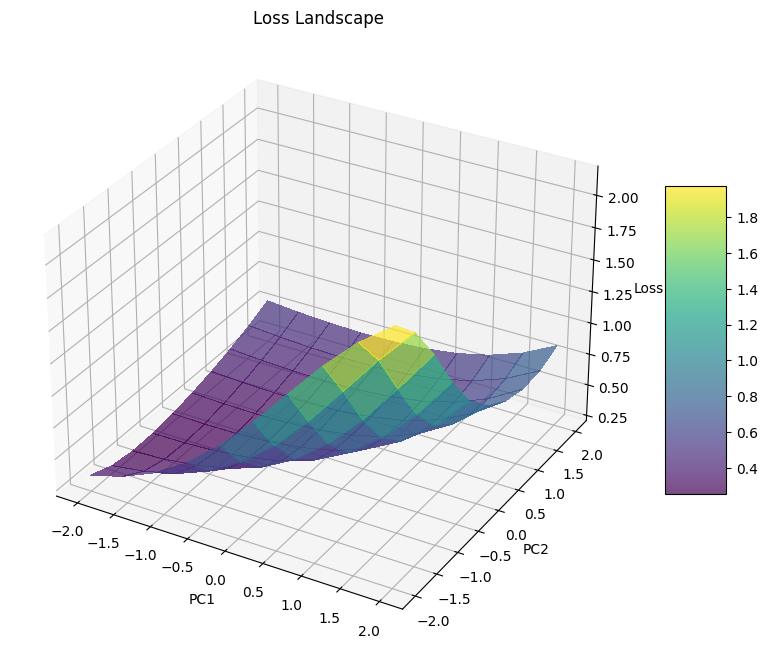

In [7]:
# Create a 3D plot of the loss
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D surface
surf = ax.plot_surface(xx, yy, losses, cmap='viridis', linewidth=0, antialiased=False, alpha=0.7)

# Add labels and title
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('Loss')
ax.set_title('Loss Landscape')

# Add a color bar
fig.colorbar(surf, shrink=0.5, aspect=5)

# Show the plot
plt.show()
